In [9]:
import os
import csv
import glob
from datetime import datetime, timedelta
import tempfile
from osgeo import gdal
import numpy as np
from scipy.ndimage import maximum_filter, binary_closing
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from rios import applier, cuiprogress, fileinfo
import mgrs
import pyproj
from requests.adapters import HTTPAdapter
from urllib3 import Retry
from pystac_client import Client
from pystac_client.stac_api_io import StacApiIO
import geopandas as gpd
from pystac_client import Client


# Set the working directory to SpectralBotany
os.chdir("/home/tim/rubella/scripts/SpectralBotany")

AOI = "data/SpectralBotanyTest.gpkg"
Layer = "BrigalowBeltAOI"


<Axes: >

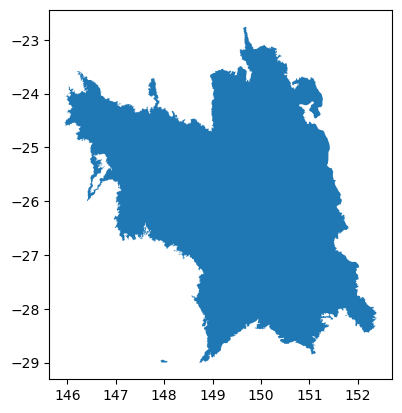

In [7]:
# Load AOI
brigalow = gpd.read_file(AOI, layer=Layer)
# Reproject to WGS84 for STAC API
brigalow.to_crs(4326, inplace=True)
# Plot to check everything looks ok
bbox = brigalow.total_bounds
brigalow.plot()

In [ ]:
# Setting GDAL environment variables
gdal_env_vars = {
    "GDAL_NUM_THREADS": "ALL_CPUS",
    "GDAL_PAM_ENABLED": "NO",
    "GDAL_CACHEMAX": "1024000000",
    "GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR",
    "GDAL_HTTP_MERGE_CONSECUTIVE_RANGES": "YES",
    "GDAL_HTTP_MULTIPLEX": "YES",
    "CPL_VSIL_CURL_ALLOWED_EXTENSIONS": ".tif,.TIF,.vrt,.zip",
    "VSI_CACHE": "True",
    "VSI_CACHE_SIZE": "1024000000",
    "GDAL_HTTP_MAX_RETRY": "10",
    "GDAL_HTTP_RETRY_DELAY": "3",
    "CPL_ZIP_ENCODING": "UTF-8"
}

for var, value in gdal_env_vars.items():
    os.environ[var] = value

gdal.UseExceptions()

# Check that the tile can actually be accessed
def check_tile(path):
    if not os.path.exists(path):
        return False
    try:
        fid = gdal.Open(path)
        # read the first pixel of the first band
        data = fid.GetRasterBand(1).ReadAsArray(0,0,1,1)
        fid = None
        return True
    except:
        # Log the error
        print('Failed to open: ' + path)
        # delete the vrt file as it's probably a nrt one that's gone
        if os.path.exists(path):
            os.remove(path)
        return False


def get_centered_bbox(tile, size=50):
    """
    Get a bounding box with specified size centered on an MGRS tile.
    
    Parameters:
    tile (str): The MGRS tile code.
    size (int): The length of each side of the bounding box in kilometers.
    
    Returns:
    list: Bounding box coordinates [west_lon, south_lat, east_lon, north_lat].
    """
    
    # Initialize MGRS and Geod objects
    m = mgrs.MGRS()
    g = pyproj.Geod(ellps='WGS84')
    
    # Convert MGRS tile to Lat/Lon to get the South-West and North-East corners
    sw_lat, sw_lon = m.toLatLon(tile + '00000' + '00000')
    ne_lat, ne_lon = m.toLatLon(tile + '99999' + '99999')
    
    # Calculate the center of the MGRS tile
    center_lat = (sw_lat + ne_lat) / 2
    center_lon = (sw_lon + ne_lon) / 2
    
    # Define the half offset distance in meters (size/2 km)
    half_offset = (size / 2) * 1000
    
    # Compute the bounding box coordinates
    west_lon, _, _ = g.fwd(center_lon, center_lat, 270, half_offset)  # move west
    east_lon, _, _ = g.fwd(center_lon, center_lat, 90, half_offset)   # move east
    _, south_lat, _ = g.fwd(center_lon, center_lat, 180, half_offset) # move south
    _, north_lat, _ = g.fwd(center_lon, center_lat, 0, half_offset)   # move north
    
    # Make a bounding box [west longitude, south latitude, east longitude, north latitude]
    bbox = [west_lon, south_lat, east_lon, north_lat]

    return bbox




def get_vrts(bbox = None, start_time=None, end_time=None, max_cloud=100):
    """
    Function to get a list of VRTs for images from the DEA STAC catalog,
    that are within the specified bounding box, time range and cloudiness.
    """

    # If no start or end time is provided, use default values.
    if end_time is None:
        end_time = datetime.now()
        print(f'No end time provided. Using current time: {end_time}')
    
    if start_time is None:
        # Find imagery up to a month ago
        start_time = end_time - timedelta(days=30)
        print(f'No start time provided. Using default start time: {start_time}')

    if bbox is None:
        # If no bounding box is provided, use a default bounding box for testing.
        bbox = [112.5, -37.5, 113.5, -36.5]
        print(f'No tile provided. Using default bounding box: {bbox}')
    
    # Format start time and end time to use in STAC query 
    time_range_start = start_time.strftime('%Y-%m-%d')
    time_range_end = end_time.strftime('%Y-%m-%d')
    time_range = f"{time_range_start}/{time_range_end}"
    
    # Define bands that we want to look for in the item assets.
    wanted_bands = [
        'nbart_blue',
        'nbart_green',
        'nbart_red',
        'nbart_red_edge_1',
        'nbart_red_edge_2',
        'nbart_red_edge_3',
        'nbart_nir_1',
        'nbart_swir_2',
        'nbart_swir_3',
        'nbart_nir_2',
        'oa_fmask',
        'oa_s2cloudless_mask',
    ]
     
     
    # Initialize empty lists to store vrt names and dates.
    vrt_names = []
    vrt_dates = []
  
    # Setup retry logic with exponential backoff for handling HTTP errors. 
    retry = Retry(total=10, backoff_factor=0.1, status_forcelist=[502, 503, 504])
    stac_api_io = StacApiIO()
    # Mount the HTTP adapter to the session instance.
    stac_api_io.session.mount("https://", HTTPAdapter(max_retries=retry))
    
    # Connect to the DEA STAC catalog using STAC client.
    client = Client.open("https://explorer.sandbox.dea.ga.gov.au/stac/")

    # Use try/except block to handle exceptions during item search and VRT creation.
    try:
        # Search for items in collections 'ga_s2am_ard_3' and 'ga_s2bm_ard_3' within the specified time range and bbox.
        s2Search = client.search(
            collections=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
            datetime=time_range,
            bbox = bbox
        )
        
        # Initialize empty dictionary to store potential VRT details before deciding to write.
        vrt_records = {}

        # Iterate over all pages of search results.
        for page in s2Search.pages():
            # Iterate over each item in a page.
            for item in page:
                # Retrieve cloud parameters from item properties.
                cloud_fmask = item.properties.get('fmask:cloud')
                cloud_cloudless = item.properties.get('s2cloudless:cloud')

                # Ignore items with cloudiness greater than max_cloud.
                if max(cloud_fmask, cloud_cloudless) <= max_cloud:
                    # Construct VRT file name using sentinel product name.
                    vrt_name = os.path.join(tempfile.gettempdir(), f'{item.properties["sentinel:product_name"]}.vrt')

                    # If final dataset is found, discard same NRT dataset if it exists	
                    if item.properties["dea:dataset_maturity"] == 'final':
                        vrt_records.pop(vrt_name, None)
 
                    # If Final dataset already exists, ignore NRT dataset
                    elif vrt_name in vrt_records:
                        continue

                    # Add item to potential VRT records.
                    vrt_records[vrt_name] = item

    except Exception as e:
        # Print exception message.
        print(e)
    # Create VRT files from unique datasets after examining all items.
    for vrt_name, item in vrt_records.items():
        # Check if VRT file already exists.
        if not check_tile(vrt_name):
            # Construct S3 links for each band.
            s3_links = ['/vsis3/' + item.assets[band].href.replace('s3://', '') for band in wanted_bands]
            # Create VRT file using GDAL.
            ds = gdal.BuildVRT(vrt_name, s3_links, separate=True, resolution='highest', resampleAlg='cubic')
            # Flush cache to ensure changes are written to disk.
            ds.FlushCache()
            ds = None
            # Hack to add overviews to DEA C3 VRTs on-the-fly. See #78.
            ds = gdal.Open(vrt_name, gdal.GA_Update)
            gdal.SetConfigOption("VRT_VIRTUAL_OVERVIEWS", "YES")
            ds.BuildOverviews("NEAR", [8,16,32])
            ds = None 
        # Append newly created VRT name to list.
        vrt_names.append(vrt_name)
        # Parse image date from item properties and add to list.
        try:
            image_date = datetime.strptime(item.properties.get('datetime'), '%Y-%m-%dT%H:%M:%S.%fZ')
        except ValueError:
            # DEA has used a different datetime format.
            image_date = datetime.strptime(item.properties.get('datetime'), '%Y-%m-%dT%H:%M:%SZ')
        vrt_dates.append(image_date)

    # Return vrt names and dates.
    return vrt_names, vrt_dates



def makeBufferKernel(buffsize):
    """
    Make a 2-d array for buffering. It represents a circle of 
    radius buffsize pixels, with 1 inside the circle, and zero outside.
    """
    bufferkernel = None
    if buffsize > 0:
        n = 2 * buffsize + 1
        (r, c) = np.mgrid[:n, :n]
        radius = np.sqrt((r - buffsize)**2 + (c - buffsize)**2)
        bufferkernel = (radius <= buffsize).astype(np.uint8)
    return bufferkernel

def summariseMedian(info, inputs, outputs, otherArgs):
    """
    summarise layers
    """
    # Get the image data - bands are 1 2 3 4 5 6 7 8 11 12 8a FMASK CLOUDLESS
    srData = np.array(inputs.images).astype('float')
    # Mask out any bad data areas
    for i in range(len(srData)):
        # FMask or No data. 1 is Valid
        fmask = srData[i,10] != 1
        # We need to buffer that out by a 2 pixel dilation using a convolution kernel
        fmask = maximum_filter(fmask, footprint = otherArgs.buffer)
        # Set the no data to nan
        srData[i,:,fmask] = np.nan
        # Get the S2 Cloudless Mask as well
        cloudless = srData[i,11] != 1
        srData[i,:,cloudless] = np.nan


    srData = bn.nanmedian(srData,axis=0)
    ## Add in the nodata values
    srData[np.isnan(srData)] = -999
    # Subset the data to the first 10 bands
    srData = srData[:10,:]
    outputs.mean = srData.astype('int16')

def medianRoutine(inImages,output):
    """
    Set up files for summarise rios function
    """
    BUFFER_SIZE = 5
    infiles = applier.FilenameAssociations()
    infiles.images = inImages
    outfiles = applier.FilenameAssociations()
    outfiles.mean = output

    otherArgs = applier.OtherInputs()
    otherArgs.buffer = makeBufferKernel(BUFFER_SIZE)

    controls = applier.ApplierControls()
    controls.progress = cuiprogress.CUIProgressBar()
    controls.setFootprintType(applier.INTERSECTION)
    controls.setReferenceImage(inImages[0])
    controls.setResampleMethod('near') 
    controls.windowxsize = 512
    controls.windowysize = 512
    controls.setOverlap(BUFFER_SIZE)
    controls.setStatsIgnore(-999)
    controls.setOutputDriverName("GTIFF")
    controls.setCreationOptions(["COMPRESS=DEFLATE",
                                 "ZLEVEL=9",
                                 "TILED=YES",
                                 "INTERLEAVE=BAND",
                                 "BIGTIFF=YES",
                                 "BLOCKXSIZE=512",
                                 "BLOCKYSIZE=512",
                                 "NUM_THREADS=ALL_CPUS"])

    applier.apply(summariseMedian, infiles, outfiles, otherArgs, controls=controls)




MAX_CLOUD = 25


# Read a file with scene names and date ranges
with open('qgcS2Tiles.csv', mode='r') as f:
    reader = csv.DictReader(f)
    tiles = list(reader)

# Process each tile
for tile in tiles:
    scene = tile['Name']
    start_date = datetime.strptime(tile['Start_Date'], '%Y-%m-%d')
    end_date = datetime.strptime(tile['End_Date'], '%Y-%m-%d')
    
    # Get the scene
    bbox = get_centered_bbox(scene, size=25)
    vrt_names, vrt_dates = get_vrts(bbox, start_date, end_date, MAX_CLOUD)
    
    # Make an output filename based on the scene and the date range
    outName = f"{scene}_{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}_{len(vrt_names)}.tif"
    
    # If the outname does not exist, run the median routine
    if not os.path.exists(outName):
        print(f'Processing {scene} from {start_date} to {end_date} with {len(vrt_names)} images.')
        # Compute the median
        medianRoutine(vrt_names, outName)
    else:
        print(f'Output file {outName} already exists. Skipping.')


In [ ]:
climate_files = [

        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_1.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_2.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_3.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_4.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_5.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_6.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_7.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_8.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_9.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_10.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_11.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_12.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_13.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_14.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_15.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_16.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_17.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_18.tif",
        "/vsis3/ozius-frankfurt-dev/ClimateVariables/wc2.1_30s_bio_19.tif",

    ]


# Build a vrt
climate_vrt = os.path.join(tempfile.gettempdir(), 'climate.vrt')
ds = gdal.BuildVRT(climate_vrt, climate_files, separate=True, resolution='highest', resampleAlg='cubic')
ds.FlushCache()
ds = None